In [1]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Generate fake data
np.random.seed(42)

# Number of observations
N = 1000

# Binary feature for whether the booking was made during rush hour (1) or not (0)
rush_hour = np.random.binomial(1, 0.5, N)

# Continuous feature for estimated ride distance (random values between 1 and 10)
ride_distance = np.random.uniform(1, 10, N)

lambda_ = 0.1 * (1 + rush_hour + ride_distance / 10)
beta = 2.0
time_to_event = 60 * np.random.weibull(beta, N) / lambda_

cancellation_threshold = 300
cancelled = (time_to_event > cancellation_threshold).astype(int)

df = pd.DataFrame({
    'wait_time': time_to_event,
    'cancelled': cancelled,
    'rush_hour': rush_hour,
    'ride_distance': ride_distance,
})

df.head()

,wait_time,cancelled,rush_hour,ride_distance
0,260.928750,0,0,2.666196
1,123.491198,0,1,5.877109
2,319.905980,1,1,8.856513
3,116.519474,0,1,7.590024
4,185.125559,0,0,8.259050


In [3]:
# Generate fake data
np.random.seed(42)

# Number of observations
N = 1000

# Binary feature for whether the booking was made during rush hour (1) or not (0)
rush_hour = np.random.binomial(1, 0.5, N)

# Continuous feature for estimated ride distance (random values between 1 and 10)
ride_distance = np.random.uniform(1, 10, N)

# Weibull-distributed time-to-event (cancellation or completion)
# Assume that bookings made during rush hour, or with long ride distances, have a lower risk of cancellation
lambda_ = 0.1 * (1 + rush_hour + ride_distance / 10)
beta = 2.0
time_to_event = 60 * np.random.weibull(beta, N) / lambda_

# Binary feature for whether each booking was cancelled (1) or completed (0)
# Assume a booking is cancelled if the wait time exceeds a certain threshold
cancellation_threshold = 300
cancelled = (time_to_event > cancellation_threshold).astype(int)

df = pd.DataFrame({
    'wait_time': time_to_event,
    'cancelled': cancelled,
    'rush_hour': rush_hour,
    'ride_distance': ride_distance,
})

df.head()

,wait_time,cancelled,rush_hour,ride_distance
0,260.928750,0,0,2.666196
1,123.491198,0,1,5.877109
2,319.905980,1,1,8.856513
3,116.519474,0,1,7.590024
4,185.125559,0,0,8.259050


# EDA

## Target Count

In [4]:
df['cancelled'].value_counts()

0    615
1    385
Name: cancelled, dtype: int64

## Distribution of Wait Time

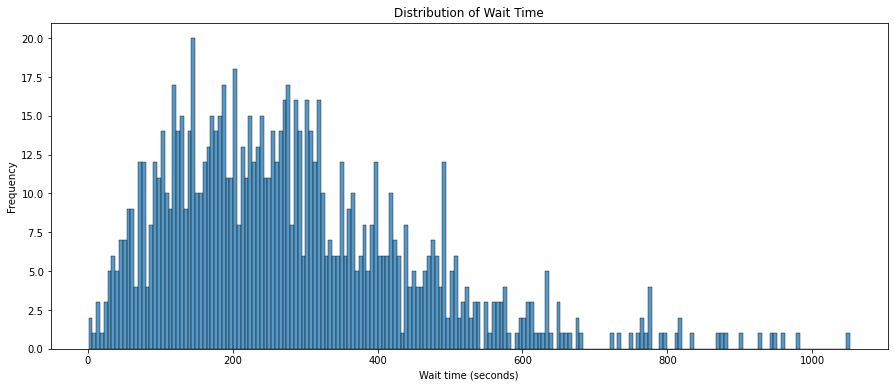

In [5]:
plt.figure(figsize=(15, 6))
sns.histplot(df['wait_time'], kde=False, bins=200)
plt.title('Distribution of Wait Time')
plt.xlabel('Wait time (seconds)')
plt.ylabel('Frequency')
plt.show()

## Feature Correlation

In [6]:
df.groupby("rush_hour")["cancelled"].mean()

rush_hour
0    0.550696
1    0.217304
Name: cancelled, dtype: float64

In [7]:
df.groupby("cancelled")["ride_distance"].mean()

cancelled
0    5.889874
1    5.041255
Name: ride_distance, dtype: float64

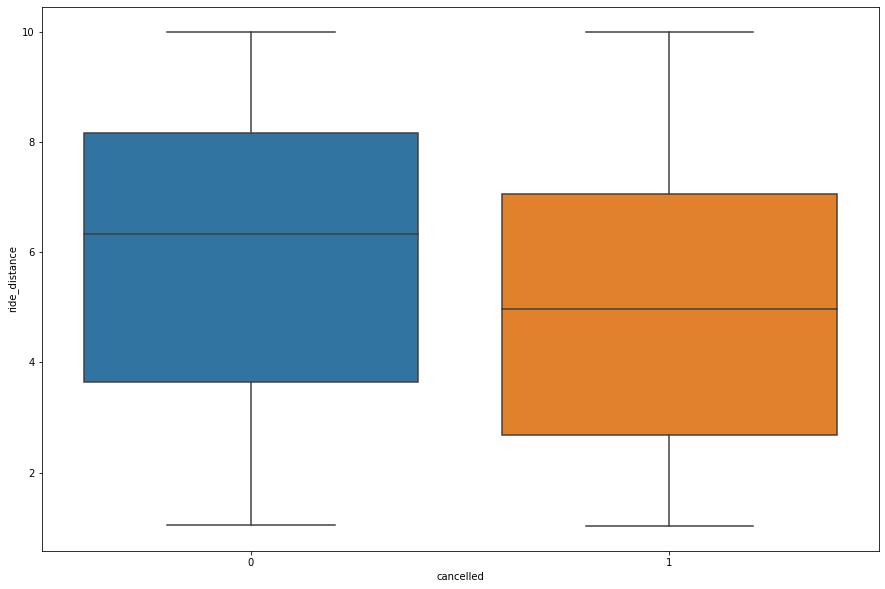

In [8]:
plt.figure(figsize=(15,10))
sns.boxplot(data=df, x="cancelled", y="ride_distance", showfliers=False)
plt.show()


# Cox Proportional Hazards(CPH) Model

## Assumptions


1. independence of survival times between individuals
2. a multiplicative relationship between the predictors and the hazard
3. a constant hazard ratio over time


The model is said to be "semi-parametric" because it makes parametric assumptions about how the hazard function h(t) depends on the covariates through the proportional hazards assumption, but it does not make any parametric assumptions about the baseline hazard function.

Instead, the CPH model estimates the baseline hazard function from the data. During the fitting process, it maximizes a partial likelihood function that depends on the ranks of the event times but not on the baseline hazard function. This allows the model to estimate the regression coefficients for the covariates without making any assumptions about the baseline hazard function.

In [9]:
from sklearn.model_selection import train_test_split
from lifelines import CoxPHFitter

In [10]:
X = df[['wait_time', 'rush_hour', 'ride_distance']]
y = df['cancelled']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train['cancelled'] = y_train
X_test['cancelled'] = y_test

# Fit the CoxPHFitter model
cph = CoxPHFitter()
cph.fit(X_train, duration_col='wait_time', event_col='cancelled')

# Print the summary of the fitted model
print(cph.print_summary())

<lifelines.CoxPHFitter: fitted with 800 total observations, 487 right-censored observations>
             duration col = 'wait_time'
                event col = 'cancelled'
      baseline estimation = breslow
   number of observations = 800
number of events observed = 313
   partial log-likelihood = -1448.67
         time fit was run = 2023-06-02 08:32:31 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
rush_hour       1.11       3.02       0.14             0.84             1.38                 2.31                 3.96
ride_distance   0.12       1.13       0.02             0.08             0.17                 1.08                 1.18

                cmp to    z      p   -log2(p)
covariate                                    
rush_hour         0.00 8.03 <0.005      49.89
ride_distance     0.00 5.26 <0.005      22.70
---
Concordance = 0.65
Partial AIC = 2901.35
log-likelihood ratio test = 81.36 on 2 df
-log2(p) of ll-ratio test = 58.69

None


# Evaluation

__Concordance Index (C-index)__: The C-index is a generalization of the Area Under the ROC Curve (AUC-ROC) used for binary classification. It measures the agreement between the predicted and observed order of events. A C-index of 0.5 indicates that the model's predictions are no better than random chance, while a C-index of 1.0 indicates perfect prediction. The C-index is easy to interpret but does not account for the actual time of the events.


Let us consider a pair of patients `(i, j)`. Intuitively, a higher risk should result in a shorter time to the adverse event. Therefore, if a model predicts a higher risk score for the first patient `(ηᵢ > ηⱼ)`, we also expect a shorter survival time in comparison with the other patient `(Tᵢ < Tⱼ)`. [reference](https://towardsdatascience.com/how-to-evaluate-survival-analysis-models-dd67bc10caae#da2f)


__Brier Score__: The Brier score is a general measure for the accuracy of probabilistic predictions. It compares the predicted probabilities of event occurrence at a specific time point with the observed status at that time point. A lower Brier score means better performance.

__Log-Likelihood__: This is an essential concept in statistics. The likelihood function calculates the "compatibility" of the model parameters with the observed data. A higher log-likelihood indicates better performance. In the case of a CPH model, you can directly get the value of the log-likelihood from the summary of the model fit

In [11]:
from lifelines.utils import concordance_index
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

In [12]:
# 1. C-index
predicted_risk = cph.predict_partial_hazard(X_test)
c_index = concordance_index(X_test['wait_time'], -predicted_risk, X_test['cancelled'])
print("C-index: ", c_index)

# 2. Brier Score
times = np.percentile(X_train['wait_time'], [50, 75, 90])  # quartiles of durations in the training data
predictions = cph.predict_survival_function(X_test, times=times)
for i, time in enumerate(times):
    event_occurred = (X_test['wait_time'] <= time) & X_test['cancelled']
    brier_score = brier_score_loss(event_occurred, 1-predictions.iloc[i])
    print(f"Brier score at time {time}: ", brier_score)

C-index:  0.6561032863849765
Brier score at time 255.9312693329934:  0.0
Brier score at time 379.7157890419169:  0.2444703147039717
Brier score at time 503.76546412323466:  0.5282178500256809


- `times = np.percentile(df['duration'], [25, 50, 75])`: We are choosing the time points at which to calculate the Brier score. Here, we're choosing the 25th, 50th, and 75th percentiles of the durations in the training data. Essentially, these are the quartiles of the observed event times.

- `predictions = cph.predict_survival_function(test_df, times=times)`: This calculates the survival function for each individual in the test set at each of the chosen times. The survival function represents the probability that an individual survives (i.e., does not experience the event) beyond a given time.


- `event_occurred = (test_df['duration'] <= time) & test_df['event']`: This calculates the actual status of the event at the given time. It is True if the event has occurred by this time (i.e., the actual duration is less than or equal to the time, and the event indicator is 1), and False otherwise.

- `brier_score = brier_score_loss(event_occurred, 1-predictions.iloc[i])`: This calculates the Brier score at the given time. The brier_score_loss function takes two arguments: the actual event status and the predicted probability of the event. Since the survival function gives the probability of survival, we subtract it from 1 to get the predicted probability of the event (i.e., 1-survival = death or failure). The brier_score_loss function then calculates the mean squared difference between these actual and predicted probabilities.

# Predict

In [13]:
new_data = pd.DataFrame({
    "rush_hour": [0, 1],
    "ride_distance": [3.2, 5.1]
})

survival_function = cph.predict_survival_function(new_data, times=[300, 400])
survival_function

,0,1
300.0,0.999117,0.996638
400.0,0.719791,0.285565


## Survival Plot

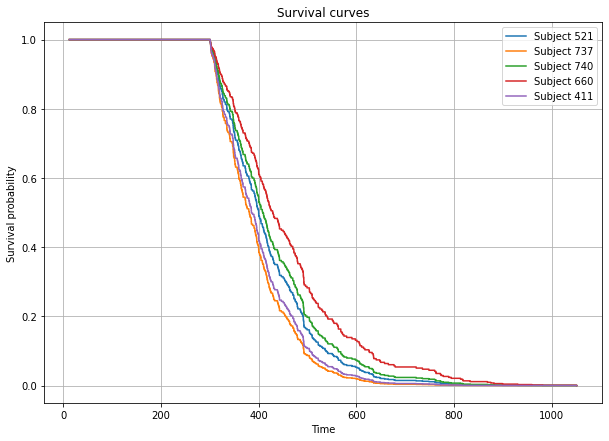

In [14]:
# index is the unique time in the training data, columns are the orders
survival_function = cph.predict_survival_function(X_test)

# Plot the survival curves
plt.figure(figsize=(10, 7))
for i, c in enumerate(survival_function.columns[:5]):
    plt.step(survival_function.index, survival_function[c], where="post", label=f'Subject {c}')

plt.ylabel("Survival probability")
plt.xlabel("Time")
plt.title("Survival curves")
plt.legend()
plt.grid(True)
plt.show()


# Schoenfeld Residual 

[reference](https://timeseriesreasoning.com/contents/schoenfeld-residuals/)

The `Schoenfeld residual` for an individual i at time t for a specific covariate (predictor variable) is defined as:

```
rs_i(t) = X_i - E[X_i | T > t]
```

where:

- rs_i(t) is the Schoenfeld residual,
- X_i is the observed value of the predictor for individual i,
- E[X_i | T > t] is the expected value of the predictor given that the event time T is greater than t.

This residual essentially measures the difference between the observed covariate value and what we would expect the covariate value to be, given that the event hasn't occurred yet.

If there are time-varying effects, the residuals will show a trend, which can be detected by statistical tests or visually in a plot.

## Applicability
The Schoenfeld residuals are primarily used to check the proportional hazards assumption (`Assumption 3: a constant hazard ratio over time`). This is done by examining whether there's a relationship between the residuals and time. If the proportional hazards assumption holds, the residuals should not exhibit a systematic pattern over time.

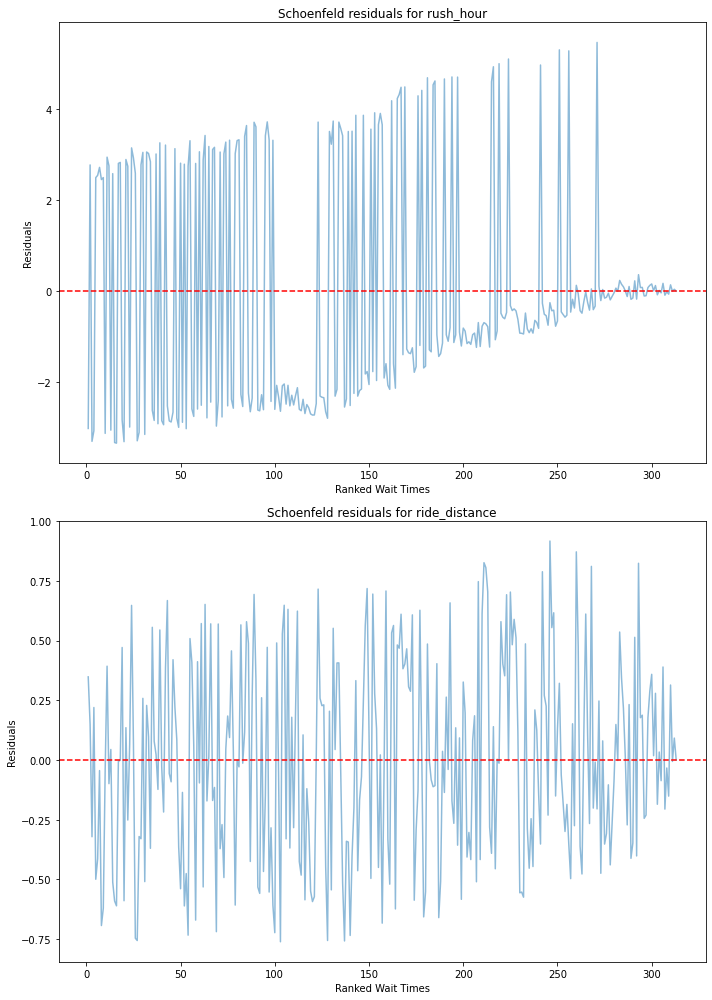

In [15]:
# Compute the scaled Schoenfeld residuals
residuals = cph.compute_residuals(X_train, 'scaled_schoenfeld')

# Rank the wait times for the subjects that have experienced the event
event_df = X_train.loc[residuals.index]
ranked_wait_times = event_df['wait_time'].rank()

# Create scatter plots of Schoenfeld residuals against ranked wait times for each variable
fig, axs = plt.subplots(len(residuals.columns), 1, figsize=(10, 7*len(residuals.columns)))

for i, col in enumerate(residuals.columns):
    axs[i].plot(ranked_wait_times, residuals[col], alpha=0.5)
    axs[i].set_title(f'Schoenfeld residuals for {col}')
    axs[i].set_xlabel('Ranked Wait Times')
    axs[i].set_ylabel('Residuals')
    axs[i].axhline(0, ls='--', color='red')

plt.tight_layout()
plt.show()


## Caveats of Binary Variables

The Schoenfeld residuals are based on comparing observed and expected covariate values, and for binary variables, these values can only take on two possible values (0 or 1). This might make any trend in the residuals less apparent or harder to detect.


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 800 total observations, 487 right-censored observations>
         test_name = proportional_hazard_test

---
                    test_statistic    p  -log2(p)
ride_distance km              4.20 0.04      4.62
              rank            4.20 0.04      4.62
rush_hour     km              0.14 0.71      0.50
              rank            0.14 0.71      0.50



1. Variable 'ride_distance' failed the non-proportional test: p-value is 0.0405.

   Advice 1: the functional form of the variable 'ride_distance' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'ride_distance' using pd.cut, and then specify it in
`strata=['ride_distance', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazar

[[<AxesSubplot: xlabel='rank-transformed time\n(p=0.7084)'>,
  <AxesSubplot: xlabel='km-transformed time\n(p=0.7084)'>],
 [<AxesSubplot: xlabel='rank-transformed time\n(p=0.0405)'>,
  <AxesSubplot: xlabel='km-transformed time\n(p=0.0405)'>]]

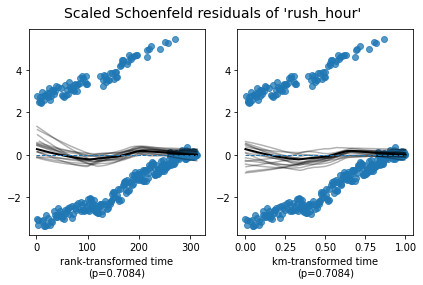

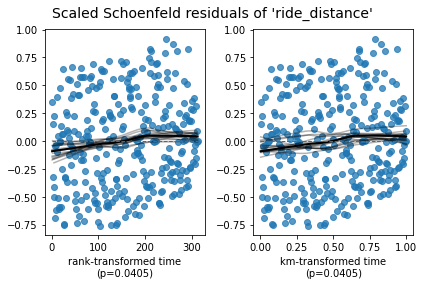

In [16]:
# this uses Schoenfeld residual test
cph.check_assumptions(X_train, p_value_threshold=0.05, show_plots=1)